# "Galfitting" with lenstronomy
An example of using **lenstronomy** without imposing a lensing deflector is the inference of galaxy structural parameters through the fitting of a parameterized surface brightness model (or many thereof).

We want to demonstrate the flexibility of **lenstronomy**. Matching the structural properties of lensing and source galaxy is an integral part of lens modelling. **lenstronomy** may provide an alternative in python to other software that are more specific to this task.
The 'lens_light_model' effectively describes undistorted surface brightness profiles in lenstronomy.

<div class="alert alert-warning">

**Warning:** Small sources and very cuspy cores (such as Sersic profiels with high Sersic indexes) result in steep surface brightness variations below the pixel scale. The numerics used in this notebook only evaluates the surface brighness in the centre of each pixel and assigns the entire pixel this surface brightness value. Super-sampled evaluation of surface brightness profiles may be required. Lenstronomy supports this, both on a grid and adaptive in specific regions. We refer to the $\texttt{Numerics}$ module and a dedicated notebook on numerical aspects.

</div>

In [1]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## create mock image as a superposition of different profiles
In the example below, we generate a galaxy image with a two component Sersic profile at the same center and a compagnion Hernquist light distribution. The data quality is comparable with wide field surveys.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10


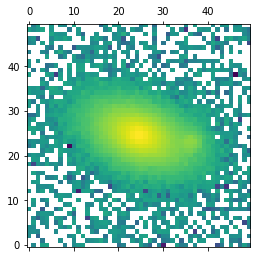

In [2]:
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# data specifics
background_rms = .05  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 50  # cutout pixel size
deltaPix = 0.3  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.8  # full width half max of PSF

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# PSF specification
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 6}
psf_class = PSF(**kwargs_psf)
# create a model with three Sersic profiles
# all the models are part of 'lens_light_model_list', meaning that their surface brightness profile are not lensed
lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'HERNQUIST']
from lenstronomy.LightModel.light_model import LightModel
lightModel = LightModel(lens_light_model_list)

kwargs_1 = {'amp': 100, 'R_sersic': .5, 'n_sersic': 3, 'e1': 0.1, 'e2': 0, 'center_x': 0, 'center_y': 0}
kwargs_2 = {'amp': 100, 'R_sersic': 1.5, 'n_sersic': 1, 'e1': 0.2, 'e2': -0.2, 'center_x': 0, 'center_y': 0}
kwargs_3 = {'amp': 100, 'Rs': 0.3, 'center_x': 3.5, 'center_y': -0.5}
kwargs_light = [kwargs_1, kwargs_2, kwargs_3]

# here we super-sample the resolution of some of the pixels where the surface brightness profile has a high gradient 
supersampled_indexes = np.zeros((numPix, numPix), dtype=bool)
supersampled_indexes[23:27, 23:27] = True

kwargs_numerics = {'supersampling_factor': 4, 
                   'compute_mode': 'adaptive',
                  'supersampled_indexes': supersampled_indexes}
from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens_light=kwargs_light)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_noisy = image_sim + bkg + poisson


data_class.update_data(image_noisy)
kwargs_data['image_data'] = image_noisy

plt.matshow(np.log10(image_noisy), origin='lower')
plt.show()


In [3]:

kwargs_model = {'lens_light_model_list': lens_light_model_list}
kwargs_constraints = {}
kwargs_likelihood = {'check_bounds': True}

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [4]:

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# first Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': .1, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

# second Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': .5, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

# Hernquist component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'Rs': 0.7, 'center_x': 3., 'center_y': 0.})
kwargs_lens_light_sigma.append({'Rs': 0.3, 'center_x': 0.5, 'center_y': 0.5})
kwargs_lower_lens_light.append({'Rs': 0.01, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'Rs': 10, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_light_model': lens_light_params}


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()



Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.9979924909244478 reduced X^2 of best position
-1238.5086812372397 logL
2482.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.5792984712296044, 'n_sersic': 2.6602378145066172, 'e1': 0.10080608104801476, 'e2': 0.019740375573647297, 'center_x': 0.00404950479343327, 'center_y': 0.0005174662625157896}, {'amp': 1, 'R_sersic': 1.4941424414524878, 'n_sersic': 1.030139508913638, 'e1': 0.20191745558312377, 'e2': -0.20397947570582767, 'center_x': -0.004482108153240048, 'center_y': 0.000938763858224636}, {'amp': 1, 'Rs': 0.3436829714258647, 'center_x': 3.4682338696420767, 'center_y': -0.4932926802342395}] lens light result
[] point source result
{} special param result
78.31399297714233 time used for  PSO


-0.9908069449897917 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.990806944989792


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


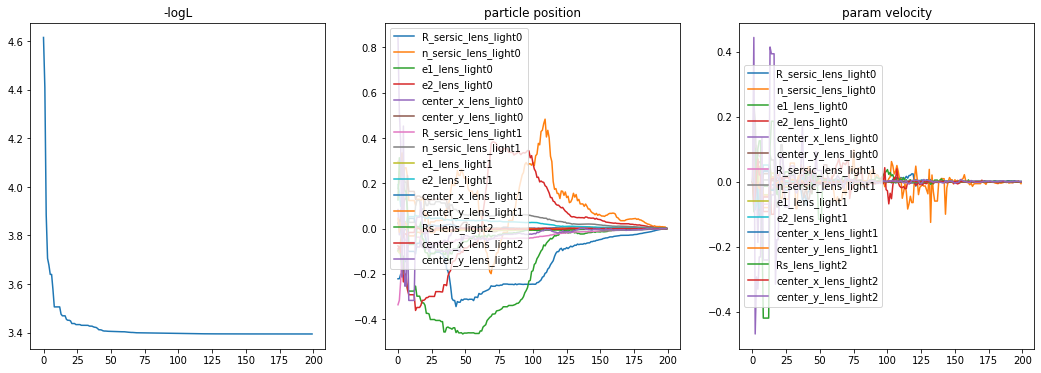

<Figure size 432x288 with 0 Axes>

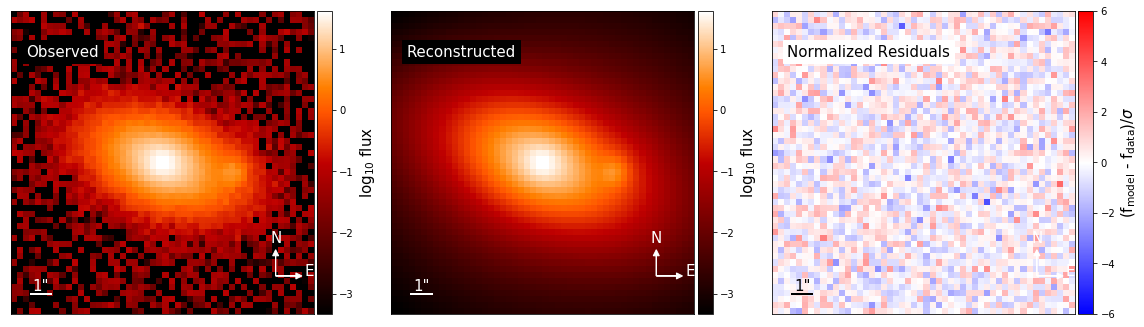

/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:517: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


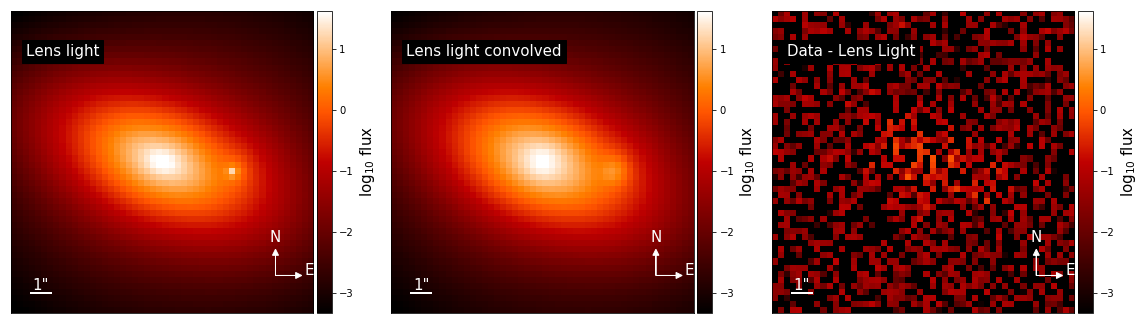

[{'amp': 83.61367288931656, 'R_sersic': 0.5792984712296044, 'n_sersic': 2.6602378145066172, 'e1': 0.10080608104801476, 'e2': 0.019740375573647297, 'center_x': 0.00404950479343327, 'center_y': 0.0005174662625157896}, {'amp': 98.44009286090153, 'R_sersic': 1.4941424414524878, 'n_sersic': 1.030139508913638, 'e1': 0.20191745558312377, 'e2': -0.20397947570582767, 'center_x': -0.004482108153240048, 'center_y': 0.000938763858224636}, {'amp': 71.18204004183846, 'Rs': 0.3436829714258647, 'center_x': 3.4682338696420767, 'center_y': -0.4932926802342395}]


In [5]:
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0])
modelPlot.model_plot(ax=axes[1])
modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)
f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1], text='Lens light convolved', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Lens Light', lens_light_add=True)
f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result['kwargs_lens_light'])